formatting tips: https://gist.github.com/nikhilnayyar002/7a35e653d3d590e317c829243e73b110
or chatgpt idk

By: Andrew Yang, Megan Yu, and Frank Deegbe

## Motivation
For decades fantasy football has dominated the landscape of sports betting by striking a perfect balance
between strategy, competition, and luck. It is a online game where participants can create their own football 
teams by selecting real life NFL players. Each participant, known as a manager, can draft these players from 
across the league, who will then earn points based on their real world game statistics every week. 

Although managers can continue to make changes to their team after the season starts, one of the most pivotal
moments of the game is the draft, where players generally select 16 players onto their initial roster in a 
snake draft. Over the years, many different strategies for drafting have emerged, such as waiting on a quarterback
(QB), drafting runningbacks (RB) and wide receivers (WR) in the earlier rounds, or waiting on a runningback to 
ensure the top talent in other positions.

Having a good draft has significant implications for the season overall. A manager is able to accept a player drafted
late to underproduce, as the draft capital for the player is not very high and could easily be cut for free agents.
However, if a player drafted within the early rounds (Rounds 1-6) underproduces, it causes significant turmoil since
the manager spent a high capital for the player and would not get equivalent return value for trading the player. 
On the other hand, drafting a sleeper player in the later rounds that massively overproduces becomes a valuable asset 
and is a critical piece of championship teams, as the overall strength of a manager's team is improved with the same 
draft cost in relation to the other teams.

A good draft strategy thus looks to minimize the risk of players within the early rounds, while is also good at finding 
the specific sleepers in the later rounds. 

Additional resources can be found here

* [https://www.espn.com/fantasy/football/story/_/id/34389554/fantasy-football-beginners-how-play-fantasy-football-2022]
* [https://www.espn.com/fantasy/football/story/_/id/39266124/2024-fantasy-football-draft-rankings-strategy-2023-takeaways]
* [https://www.si.com/fantasy/top-10-fantasy-football-rookies-nfl-draft-2024-01hxs07j8ck3]
* [https://www.rotoballer.com/rb-dead-zone-what-is-it-and-do-you-really-need-to-avoid-it/1192614]
* [https://draftwizard.fantasypros.com/football/mock-draft-simulator/settings/]
* [https://www.rotoballer.com/fantasy-football-teams-in-a-vacuum/1164424]

Based on the resources above, we have found the following questions to answer in order to determine the players strategy at 
a particular round.

* Does the runningback dead zone exist?
* Is drafting a quarterback or tight end within the first 3 rounds worth the investment?
* Which position has the most amount of sleepers?
* How can we predict the number of points that will be scored by a player in a specific round in 2024?

The objective of this project is to use statistics and data science to answer the questions above. We hope that through this
tutorial, the reader will gain a better understanding of the various draft strategies used in fantasy football as well as 
better understand how concepts within data science can more accurately model the performance of NFL players.

## Procedure

We will be using the following datasets

* [NFL-Season-DATA](https://github.com/hvpkod/NFL-Data) dataset.
* [Average-Draft-Positions](https://www.fantasypros.com/nfl/adp/ppr-overall.php) dataset.

Each dataset contains statistics of NFL players dating back to 2015, with the first dataset detailing their
in season performance and the second dataset containing their average draft positions on various fantasy 
football platforms.

We will track the following seasons: 2020, 2021, 2022, 2023, combining the two datasets together for each season. 

We will then create 4 different data frames represented for each season. If we need to measure a specific player, 
we will aggregate the 4 different dataframes together, and we would exclude players who have retired within the time
frame (2020-2023), meaning 1st, 2nd, and 3rd year players would be included.

# Part 1: Data Collection
### Get NFL-Data
Data extracted from Fantasy.NFL.com divided by season and player position, along with weekly numbers for the 2021 season.

The extract goes back to the 2015 season as that is the first available season with a full dataset for all positions.

Point total and player-ranks are specific for the MML leagues point system but all outer data are raw and can be used for other calculations and simulations.

All data are available in comma-separated csv files or row-divided JSON.

During this project, we will be using Python language, and we use tools such as [VS Code](https://code.visualstudio.com/) and [Jupiter Notebook](https://jupyter.org/) to develop this project.

Just like any other Python project, we need to import some libraries. Here are some of the libraries we will be using throughout this tutorial.

<center><b>Imports</b></center>


In [1]:
# !pip install numpy pandas seaborn matplotlib folium
import os
import folium
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
# this is just an example idk if we gonna need em

From NFL-Data git repo, we get data for running backs, wide receivers, tight ends, and quarterbacks for years 2020-2023. We read each year into a separate dataframe. Displayed below the code are the top five running backs of 2023, as well as their statistics. Their positive contributions are input into a formula which outputs their "Total Points" - the fianl column. We will use Total Points to rank players to analyze their performance.

Many of the players listed toward the bottom of the rankings have 0 total points. This is because they did not play. We do not need to consider the lowest scoring players in each year, so we will only consider the top 50 performers of each year. For quarterbacks and tight ends, we will only refer to the top 32 performers for each year.

In [2]:
years = ["2020", "2021", "2022", "2023"]
# array of dataframes containing RB data for years 2020-2023
rb_dfs = []
for year in years:
    rb_url = "https://raw.githubusercontent.com/hvpkod/NFL-Data/main/NFL-data-Players/"+ year +"/RB_season.csv"
    rb_df = pd.read_csv(rb_url)
    rb_df = rb_df.head(50)
    # remove jr
    rb_df['PlayerName'] = rb_df['PlayerName'].str.replace(r'\s+(Jr|Sr)\.?$', '', regex=True)
    rb_dfs.append(rb_df)

rb_dfs[-1].head()

,PlayerName,PlayerId,Pos,Team,PassingYDS,PassingTD,PassingInt,RushingYDS,RushingTD,ReceivingRec,...,TouchReceptions,Touches,TargetsReceptions,Targets,ReceptionPercentage,RzTarget,RzTouch,RzG2G,Rank,TotalPoints
0,Christian McCaffrey,2557997,RB,SF,NaN,NaN,NaN,1459.0,14.0,67.0,...,67.0,339.0,67.0,83.0,81.0,16.0,75.0,39.0,1,359.80
1,Travis Etienne,2566157,RB,JAX,NaN,NaN,NaN,1008.0,11.0,58.0,...,58.0,325.0,58.0,73.0,79.0,2.0,39.0,15.0,2,256.40
2,Breece Hall,2568030,RB,NYJ,NaN,NaN,NaN,994.0,5.0,76.0,...,76.0,299.0,76.0,95.0,80.0,5.0,25.0,17.0,3,254.50
3,Raheem Mostert,2553728,RB,MIA,NaN,NaN,NaN,1012.0,18.0,25.0,...,25.0,234.0,25.0,32.0,78.0,5.0,50.0,32.0,4,250.17
4,Joe Mixon,2557976,RB,CIN,NaN,NaN,NaN,1034.0,9.0,52.0,...,52.0,309.0,52.0,64.0,81.0,13.0,67.0,42.0,5,241.00


In [3]:
years = ["2020", "2021", "2022", "2023"]
# array of dataframes containing QB data for years 2020-2023
qb_dfs = []
for year in years:
    qb_url = "https://raw.githubusercontent.com/hvpkod/NFL-Data/main/NFL-data-Players/"+ year +"/QB_season.csv"
    qb_df = pd.read_csv(qb_url)
    qb_df = qb_df.head(32)
    # remove jr
    qb_df['PlayerName'] = qb_df['PlayerName'].str.replace(r'\s+(Jr|Sr)\.?$', '', regex=True)
    qb_dfs.append(qb_df)

qb_dfs[-1].head()

,PlayerName,PlayerId,Pos,Team,PassingYDS,PassingTD,PassingInt,RushingYDS,RushingTD,ReceivingRec,...,TouchReceptions,Touches,TargetsReceptions,Targets,ReceptionPercentage,RzTarget,RzTouch,RzG2G,Rank,TotalPoints
0,Josh Allen,2560955,QB,BUF,4306.0,29.0,18.0,524.0,15.0,NaN,...,NaN,111.0,NaN,NaN,NaN,NaN,35.0,18.0,1,387.51
1,Jalen Hurts,2564832,QB,PHI,3858.0,23.0,15.0,605.0,15.0,NaN,...,NaN,157.0,NaN,NaN,NaN,NaN,43.0,26.0,2,354.22
2,Dak Prescott,2555260,QB,DAL,4516.0,36.0,9.0,242.0,2.0,NaN,...,NaN,55.0,NaN,NaN,NaN,NaN,13.0,5.0,3,341.31
3,Lamar Jackson,2560757,QB,BAL,3678.0,24.0,7.0,821.0,5.0,NaN,...,NaN,148.0,NaN,NaN,NaN,NaN,30.0,10.0,4,325.59
4,Jordan Love,2564007,QB,GB,4159.0,32.0,11.0,247.0,4.0,NaN,...,NaN,50.0,NaN,NaN,NaN,NaN,9.0,5.0,5,309.86


In [4]:
years = ["2020", "2021", "2022", "2023"]
# array of dataframes containing QB data for years 2020-2023
wr_dfs = []
for year in years:
    wr_url = "https://raw.githubusercontent.com/hvpkod/NFL-Data/main/NFL-data-Players/"+ year +"/WR_season.csv"
    wr_df = pd.read_csv(wr_url)
    wr_df = wr_df.head(50)
    # remove jr
    wr_df['PlayerName'] = wr_df['PlayerName'].str.replace(r'\s+(Jr|Sr)\.?$', '', regex=True)
    wr_dfs.append(wr_df)

wr_dfs[-1].head()

,PlayerName,PlayerId,Pos,Team,PassingYDS,PassingTD,PassingInt,RushingYDS,RushingTD,ReceivingRec,...,TouchReceptions,Touches,TargetsReceptions,Targets,ReceptionPercentage,RzTarget,RzTouch,RzG2G,Rank,TotalPoints
0,CeeDee Lamb,2563848,WR,DAL,NaN,NaN,NaN,113.0,2.0,135.0,...,135.0,149.0,135.0,181.0,75.0,31.0,20.0,22.0,1,336.2
1,Tyreek Hill,2556214,WR,MIA,NaN,NaN,NaN,15.0,NaN,119.0,...,119.0,125.0,119.0,171.0,70.0,23.0,14.0,14.0,2,324.4
2,Amon-Ra St. Brown,2566073,WR,DET,NaN,NaN,NaN,24.0,NaN,119.0,...,119.0,123.0,119.0,164.0,73.0,23.0,16.0,11.0,3,279.1
3,DJ Moore,2560813,WR,CHI,NaN,NaN,NaN,21.0,1.0,96.0,...,96.0,100.0,96.0,136.0,71.0,11.0,8.0,7.0,4,246.5
4,Puka Nacua,2570026,WR,LA,NaN,NaN,NaN,89.0,NaN,105.0,...,105.0,117.0,105.0,160.0,66.0,16.0,11.0,11.0,5,246.5


In [5]:
years = ["2020", "2021", "2022", "2023"]
# array of dataframes containing QB data for years 2020-2023
te_dfs = []
for year in years:
    te_url = "https://raw.githubusercontent.com/hvpkod/NFL-Data/main/NFL-data-Players/"+ year +"/TE_season.csv"
    te_df = pd.read_csv(te_url)
    te_df = te_df.head(32)
    # remove jr
    te_df['PlayerName'] = te_df['PlayerName'].str.replace(r'\s+(Jr|Sr)\.?$', '', regex=True)
    te_dfs.append(te_df)

te_dfs[-1].head()

,PlayerName,PlayerId,Pos,Team,PassingYDS,PassingTD,PassingInt,RushingYDS,RushingTD,ReceivingRec,...,TouchReceptions,Touches,TargetsReceptions,Targets,ReceptionPercentage,RzTarget,RzTouch,RzG2G,Rank,TotalPoints
0,Sam LaPorta,2569726,TE,DET,NaN,NaN,NaN,4.0,NaN,86.0,...,86.0,87.0,86.0,120.0,72.0,15.0,11.0,15.0,1,199.6
1,Evan Engram,2557858,TE,JAX,NaN,NaN,NaN,NaN,NaN,114.0,...,114.0,114.0,114.0,143.0,80.0,9.0,6.0,4.0,2,176.8
2,Travis Kelce,2540258,TE,KC,NaN,NaN,NaN,NaN,NaN,93.0,...,93.0,93.0,93.0,121.0,77.0,19.0,13.0,12.0,3,174.4
3,T.J. Hockenson,2562378,TE,MIN,NaN,NaN,NaN,NaN,NaN,95.0,...,95.0,95.0,95.0,127.0,75.0,9.0,6.0,9.0,4,173.0
4,George Kittle,2558266,TE,SF,NaN,NaN,NaN,2.0,NaN,65.0,...,65.0,66.0,65.0,90.0,72.0,12.0,8.0,6.0,5,172.2


### Get ADP Rankings Data
From fantasypros website, we get the Average Draft Position (ADP) for all players in years 2020-2023. 
We drop all the irrelevant columns to only keep name and average ADP.

Some players names have Jr or Jr. at the end. Sometimes one database will include the suffix while another will not. Moreover, the suffix may or may not have a period. This poses a problem because we need to merge databases together by name. Since there is so much variability, we decided to remove the Jr from all names if it exists. We do so with regex.

In [6]:
# array of dataframes containing Overall ADP data for years 2020-2023
adp_overall_dfs = []

# we only need the AVG ADP column, so we can drop all others
columns_to_drop = ['Rank', 'Team', 'Bye', 'ESPN', 'Sleeper', 'NFL', 'RTSports', 'FFC']

for year in years:
    path = "./Data/FantasyPros_" + year + "_Overall_ADP_Rankings.csv"
    df = pd.read_csv(path)
    df.drop(columns=columns_to_drop, axis=1, inplace=True)
    df['Player'] = df['Player'].str.replace(r'\s+(Jr|Sr)\.?$', '', regex=True)
    adp_overall_dfs.append(df)

    # Fill N/A values with an empty string
    df['POS'] = df['POS'].fillna('')

adp_overall_dfs[-1].head()

,Player,POS,AVG
0,Christian McCaffrey,RB1,1.8
1,Austin Ekeler,RB2,4.3
2,Ja'Marr Chase,WR1,4.5
3,Tyreek Hill,WR2,4.8
4,Travis Kelce,TE1,6.5


We will now create the dataframes for the runningbacks, wide receivers, quarterbacks, and tight ends.

In [7]:
# Function to filter WRs from each dataframe
def filter_wrs(df):
    return df[df['POS'].str.startswith('WR')]

def filter_rbs(df):
    return df[df['POS'].str.startswith('RB')]

def filter_qbs(df):
    return df[df['POS'].str.startswith('QB')]

def filter_tes(df):
    return df[df['POS'].str.startswith('TE')]

In [8]:
# Create a list of dataframes containing only WRs for each year
adp_wrs_dfs = [filter_wrs(df) for df in adp_overall_dfs]

# Example: Display the head of the WR dataframe for the last year
adp_wrs_dfs[-1].head()

,Player,POS,AVG
2,Ja'Marr Chase,WR1,4.5
3,Tyreek Hill,WR2,4.8
5,Stefon Diggs,WR3,8.8
6,Justin Jefferson,WR4,9.3
8,A.J. Brown,WR5,11.8


In [9]:
# Create a list of dataframes containing only WRs for each year
adp_rbs_dfs = [filter_rbs(df) for df in adp_overall_dfs]

# Example: Display the head of the WR dataframe for the last year
adp_rbs_dfs[-1].head()

,Player,POS,AVG
0,Christian McCaffrey,RB1,1.8
1,Austin Ekeler,RB2,4.3
7,Bijan Robinson,RB3,10.3
9,Saquon Barkley,RB4,12.0
11,Tony Pollard,RB5,13.5


In [10]:
# Create a list of dataframes containing only WRs for each year
adp_qbs_dfs = [filter_qbs(df) for df in adp_overall_dfs]

# Example: Display the head of the WR dataframe for the last year
adp_qbs_dfs[-1].head()

,Player,POS,AVG
13,Patrick Mahomes II,QB1,15.3
17,Jalen Hurts,QB2,20.3
20,Josh Allen,QB3,22.3
35,Lamar Jackson,QB4,38.0
37,Justin Herbert,QB5,43.8


In [11]:
# Create a list of dataframes containing only WRs for each year
adp_tes_dfs = [filter_tes(df) for df in adp_overall_dfs]

# Example: Display the head of the WR dataframe for the last year
adp_tes_dfs[-1].head()

,Player,POS,AVG
4,Travis Kelce,TE1,6.5
24,Mark Andrews,TE2,32.3
34,T.J. Hockenson,TE3,37.8
45,George Kittle,TE4,52.3
57,Darren Waller,TE5,64.8


# Part 2: Data Processing

Merge ADP data into NFL-Data dataframe by player name. We do a left merge, essentially adding ADP ranking to our dataframe of all NFL-Data. Once it's merged together, we drop the repeat Player name column.

In [12]:
for i in range(4):
    rb_dfs[i] = pd.merge(rb_dfs[i], adp_overall_dfs[i], how="left", left_on="PlayerName", right_on="Player")
    # drop repeat player name column
    rb_dfs[i].drop(columns=['Player'], axis=1, inplace=True)

rb_dfs[-1].head()

,PlayerName,PlayerId,Pos,Team,PassingYDS,PassingTD,PassingInt,RushingYDS,RushingTD,ReceivingRec,...,TargetsReceptions,Targets,ReceptionPercentage,RzTarget,RzTouch,RzG2G,Rank,TotalPoints,POS,AVG
0,Christian McCaffrey,2557997,RB,SF,NaN,NaN,NaN,1459.0,14.0,67.0,...,67.0,83.0,81.0,16.0,75.0,39.0,1,359.80,RB1,1.8
1,Travis Etienne,2566157,RB,JAX,NaN,NaN,NaN,1008.0,11.0,58.0,...,58.0,73.0,79.0,2.0,39.0,15.0,2,256.40,RB8,23.5
2,Breece Hall,2568030,RB,NYJ,NaN,NaN,NaN,994.0,5.0,76.0,...,76.0,95.0,80.0,5.0,25.0,17.0,3,254.50,RB9,34.0
3,Raheem Mostert,2553728,RB,MIA,NaN,NaN,NaN,1012.0,18.0,25.0,...,25.0,32.0,78.0,5.0,50.0,32.0,4,250.17,RB35,114.8
4,Joe Mixon,2557976,RB,CIN,NaN,NaN,NaN,1034.0,9.0,52.0,...,52.0,64.0,81.0,13.0,67.0,42.0,5,241.00,RB12,36.0


Now we will add one more column to the dataset, which contains the average round in which the running backs are drafted in. We calculate this with by dividing the average draft position *(ADP)* by 12 (the standard league size). This will come in useful during our exploratory data analysis.

In [13]:
for i in range(4):
    rb_dfs[i]['Round_Drafted'] = np.floor(rb_dfs[i]['AVG'] / 12) + 1

rb_dfs[-1].head()

,PlayerName,PlayerId,Pos,Team,PassingYDS,PassingTD,PassingInt,RushingYDS,RushingTD,ReceivingRec,...,Targets,ReceptionPercentage,RzTarget,RzTouch,RzG2G,Rank,TotalPoints,POS,AVG,Round_Drafted
0,Christian McCaffrey,2557997,RB,SF,NaN,NaN,NaN,1459.0,14.0,67.0,...,83.0,81.0,16.0,75.0,39.0,1,359.80,RB1,1.8,1.0
1,Travis Etienne,2566157,RB,JAX,NaN,NaN,NaN,1008.0,11.0,58.0,...,73.0,79.0,2.0,39.0,15.0,2,256.40,RB8,23.5,2.0
2,Breece Hall,2568030,RB,NYJ,NaN,NaN,NaN,994.0,5.0,76.0,...,95.0,80.0,5.0,25.0,17.0,3,254.50,RB9,34.0,3.0
3,Raheem Mostert,2553728,RB,MIA,NaN,NaN,NaN,1012.0,18.0,25.0,...,32.0,78.0,5.0,50.0,32.0,4,250.17,RB35,114.8,10.0
4,Joe Mixon,2557976,RB,CIN,NaN,NaN,NaN,1034.0,9.0,52.0,...,64.0,81.0,13.0,67.0,42.0,5,241.00,RB12,36.0,4.0


# Part 3: Exploratory Analysis & Data Visualization

We will plot the ADP of players across positions against their total points to see if people are actually drafting the best players first.

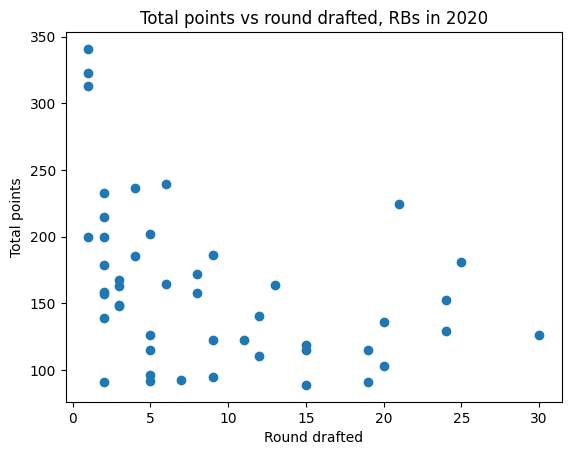

In [15]:
plt.figure()
# ex: for 2020, rbs, 
plt.title('Total points vs round drafted, RBs in 2020')
plt.xlabel('Round drafted')
plt.ylabel('Total points')
plt.scatter(rb_dfs[0]["Round_Drafted"], rb_dfs[0]["TotalPoints"])
plt.show()

# Part 4: Model: Analysis, Hypothesis Testing, ML

### Does the Runningback dead zone exist?

The running back dead zone is defined as the space around rounds three to six, where there is a significant drop off in value for the runningbacks available. This is believed to occur because many NFL teams use a running back by committee approach, where 2 or 3 runningbacks will be used in a game. As a result, the points each of them score is expected to be lower. 

Many draft strategies have appeared from this belief, such as zero-RB [https://www.fantasylife.com/articles/best-ball/what-is-zero-rb-drafting-tips-from-a-pro] (link), where the player does not believe this dead zone exists and only starts to draft RBs after round 4 or 5, and hero-RB [https://www.espn.com/fantasy/football/story/_/id/38191251/fantasy-football-mock-draft-strategy-hero-rb-anchor-rb](link), where the player drafts multiple runningbacks within the first 3 rounds.

We aim to test this, with our null hypothesis bring that the running back deadzone does exist and our alternative hypothesis being that the runningback deadzone does exist.

To measure if there is a deadzone, we will look at the difference between the average amounts of points a running back scores for each round
between 2020 and 2023. If the difference is not linear we can conclude that a drop off does exist.

### Is drafting a quarterback or tight end within the first 3 rounds worth the investment?

Another pattern many managers employ is holding off on drafting a quarterback in the early rounds, believing that there would 
be significant amounts of high performing quarterbacks in later rounds [https://campus2canton.com/breaking-down-the-late-round-qb-cff-draft-strategy/](link). On the other hand, managers race to draft a top 3 tight end, believing they have a significant drop off as well [https://www.draftsharks.com/article/fantasy-football-draft-preview-tight-ends](link).

We create two hypothesis tests to answer this question. 

Test 1
* H<sub>0</sub>: The top 3 quarterbacks drafted do not substantially outproduce quarterbacks drafted outside of the top 3
* H<sub>1</sub>: The top 3 quarterbacks drafted do substantially outproduce quarterbacks drafted outside of the top 3

Test 2
* H<sub>0</sub>: The top 3 tight ends drafted do not substantially outproduce tight ends drafted outside of the top 3
* H<sub>1</sub>: The top 3 tight ends drafted do substantially outproduce tight ends drafted outside of the top 3

# Part 5: Interpretation / Insight